# Synthetic Human Contact Network

This is the first step in creating the Urban Transportation Disease Spread Simulator. Synthetic Human Contact Network is the backbone of the simulator (TranEpiSim). I utilized the methodology proposed by [**Burger et al. (2017)**](https://dl.acm.org/doi/abs/10.1145/3145574.3145593?casa_token=z6J9RUlCP3UAAAAA:7Ie0L7W9_bmIsaR9JHfutQgyYJ9aIj0dC2ZnuGhQaF4x46QOczVq1FwfH7dsDloAcwDCH26pjOM) to create a large-scale human contact network adapted for a disease system. The code for constructing the network was obtained from **Talha Oz's** Jupyter notebook repository, which provides detailed instructions and can be accessed [**here**](https://nbviewer.org/gist/oztalha/a1c167f3879c5b95f721acef791c8111/Population%20Synthesis%20for%20ABM.ipynb). It has wondeful instructions and you can start from there if you want to develop a network for your own application. I will provide concise instructions and details for this notebook unless changes are made to the network.



## 1. Install requirements


* graph-tool documentation:

    https://graph-tool.skewed.de/static/doc/index.html
* See here for instructions how to install graph-tool on different platforms, including Colab:

    https://graph-tool.skewed.de/static/doc/index.html#installing-graph-tool

    https://git.skewed.de/count0/graph-tool/-/wikis/installation-instructions

* To import a library that's not in Colaboratory by default, you can use !apt-get install. Since graph-tool is not in the official repository, we need to add it to the list.

In [ ]:
!echo "deb http://downloads.skewed.de/apt focal main" >> /etc/apt/sources.list
!apt-key adv --keyserver keyserver.ubuntu.com --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

In [ ]:
# Colab uses a Python install that deviates from the system's! Bad collab! We need some workarounds.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

In [ ]:
!pip install signatory # May take some time...

In [ ]:
!pip install pandas geopandas mapclassify rtree simpledbf

In [ ]:
!apt-get install gtk+3

In [ ]:
!pip install seaborn plotly

## 2. Add required packages


* See the Requirement.txt for all required packages.
* To utilize Google Colaboratory, it is necessary to mount your Google Drive.

In [7]:
from google.colab import drive
drive.mount('gdrive')

Mounted at gdrive


In [ ]:
# General:
import os
import sys
import multiprocessing
from multiprocessing import pool
from multiprocessing import *
from io import StringIO
from IPython.display import display, HTML, Image
import numpy as np
import pandas as pd
import pickle
import datetime as dt
from datetime import timedelta, date
import timeit
import gzip
import shutil
from functools import partial
from dateutil.parser import parse
from concurrent.futures import ThreadPoolExecutor
from itertools import chain
from glob import glob
from sklearn.preprocessing import normalize
import random
# import rtree
import mapclassify

# Spatial:
import geopandas as gpd
from shapely.prepared import prep
from shapely.ops import snap, linemerge, nearest_points
from shapely.geometry import MultiLineString, LineString, Point, Polygon, GeometryCollection
# import pygeos

# Visualization:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.animation as ani
from matplotlib import rc
import matplotlib.dates as mdates
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Graph analyses:
from graph_tool.all import graph_tool as gt
from graph_tool.all import *
import networkx as nx
#import cairo

In [61]:
# General:
import os
import sys
import numpy as np
import pandas as pd
import timeit
from itertools import chain
import pickle
from sklearn.preprocessing import normalize

# Spatial:
import geopandas as gpd
from shapely.geometry import MultiLineString, LineString, Point, Polygon, GeometryCollection

# Visualization:
import matplotlib as mpl
from matplotlib import pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

# Graph analyses:
from graph_tool.all import graph_tool as gt
from graph_tool.all import *
import networkx as nx

## 3. Data sources

**3.1. Roads:** 2010 Census TIGER [shapefiles.](https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2010&layergroup=Roads)(soon will be updated with census 2020.)

**3.2. Demographics:** 2010 Census-tract level [Demographic Profile (DP).](https://www.census.gov/programs-surveys/decennial-census/guidance/2010/2010-data-products-at-a-glance.html)(Soon will be updated with census 2020.)

**3.3. School:** The Educational Institution [dataset.](https://geodata.epa.gov/arcgis/rest/services/OEI/ORNL_Education/MapServer)

**3.4. Establishment numbers:** Census Bureau’s County Business Patterns [(CBP).](https://www.census.gov/data/datasets/2010/econ/cbp/2010-cbp.html)

**3.5. Workflow:** Census Bureau’s Longitudinal Employer- Household Dynamics (LEHD) Origin-Destination Employment Statistics [(LODES).](https://lehd.ces.census.gov/data/)

In [9]:
os.chdir('/content/gdrive/MyDrive/TranEpiSim')
# 1. Road file
road = gpd.read_file('data/road/roads.shp')

# 2. Demographic profile
dp = gpd.read_file('data/dp/dp.shp').set_index('GEOID10')
dp['portion'] = dp.apply(lambda tract: tract.geometry.area / tract.Shape_Area, axis=1)

# 3. Schools and daycares
school = gpd.read_file('data/education/school.shp')
daycare = gpd.read_file('data/education/day_care.shp')

# 4. Number of establishments per county per size
cbp = pd.read_csv('data/cbp/cbp10co.zip')
cbp = cbp[(cbp.naics.str.startswith('-'))] #All types of establishments included
cbp['fips'] = cbp.fipstate.map("{:02}".format) + cbp.fipscty.map("{:03}".format)
cbp = cbp.set_index('fips')

# 5. Origin (home) - destination (job) at census-tract level
od = pd.read_csv('data/od/tract-od15Cook.csv',
                 dtype={i:(str if i<2 else int) for i in range(6)})

<ipython-input-9-0ba614087c18>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cbp['fips'] = cbp.fipstate.map("{:02}".format) + cbp.fipscty.map("{:03}".format)


## 4. Synthesize and save population

In [10]:
sys.path.insert(0,"src/")
import synthesizer as syn

#Add workplace counts and sizes to dp
dp['WP_CNT'] = syn.number_of_wp(dp,od,cbp)
dp['WP_PROBA'] = dp.WP_CNT.map(syn.wp_proba)

# Create a unified file for education
school = syn.clean_schools(school,daycare)

population = []
errors = []
wps = []
%prun
dp.apply(lambda t: syn.synthesize(t,od,road,school,errors, population, wps, dp),axis=1)

# Save the results
with open('output/errors.pkl', 'wb') as f:
    pickle.dump(errors, f)
with open('output/population.pkl', 'wb') as f:
    pickle.dump(population, f)
with open('output/wps.pkl', 'wb') as f:
    pickle.dump(wps, f)

 17031840300 started... 17031840300 now ended (4.3 secs)
17031840200 started... 17031840200 now ended (2.8 secs)
17031841100 started... 17031841100 now ended (8.7 secs)
17031841200 started... 17031841200 now ended (6.0 secs)
17031838200 started... 17031838200 now ended (1.6 secs)
17031770201 started... 17031770201 now ended (7.1 secs)
17031804610 started... 17031804610 now ended (2.6 secs)
17031804715 started... 17031804715 now ended (3.5 secs)
17031804108 started... 17031804108 now ended (4.8 secs)
17031803701 started... 17031803701 now ended (3.1 secs)
17031650301 started... 17031650301 now ended (6.3 secs)
17031530503 started... 17031530503 now ended (5.7 secs)
17031530501 started... 17031530501 now ended (5.4 secs)
17031760803 started... 17031760803 now ended (7.6 secs)
17031540102 started... 17031540102 now ended (3.4 secs)
17031540101 started... 17031540101 now ended (4.0 secs)
17031440201 started... 17031440201 now ended (5.8 secs)
17031839000 started... 17031839000 now ended (8

## 5. Create and save the network

In [15]:
sys.path.insert(0,"src/")
import synthesizer as syn

# Read synthesized population
with open('output/population.pkl','rb') as f:
    people = pd.concat(pickle.load(f))

# Create and save the networks
g = syn.create_networks(people,k=31,p=.3)
nx.write_gml(g,'output/contact_network.gml')

# Create networks by contact types
for etype in ['hhold','work','school']:
    sg = nx.Graph([(u,v) for u,v,d in g.edges(data=True) if d['etype']==etype])
    nx.write_gml(sg, f'output/{etype}_contact_network.gml')

# Create a network for work-school contacts
work_school = nx.Graph([(u,v) for u,v,d in g.edges(data=True) if d['etype'] in ['work','school']])
nx.write_gml(work_school,'work_school_contact_network.gml')

## 6. Results

6.1 Percentage errors

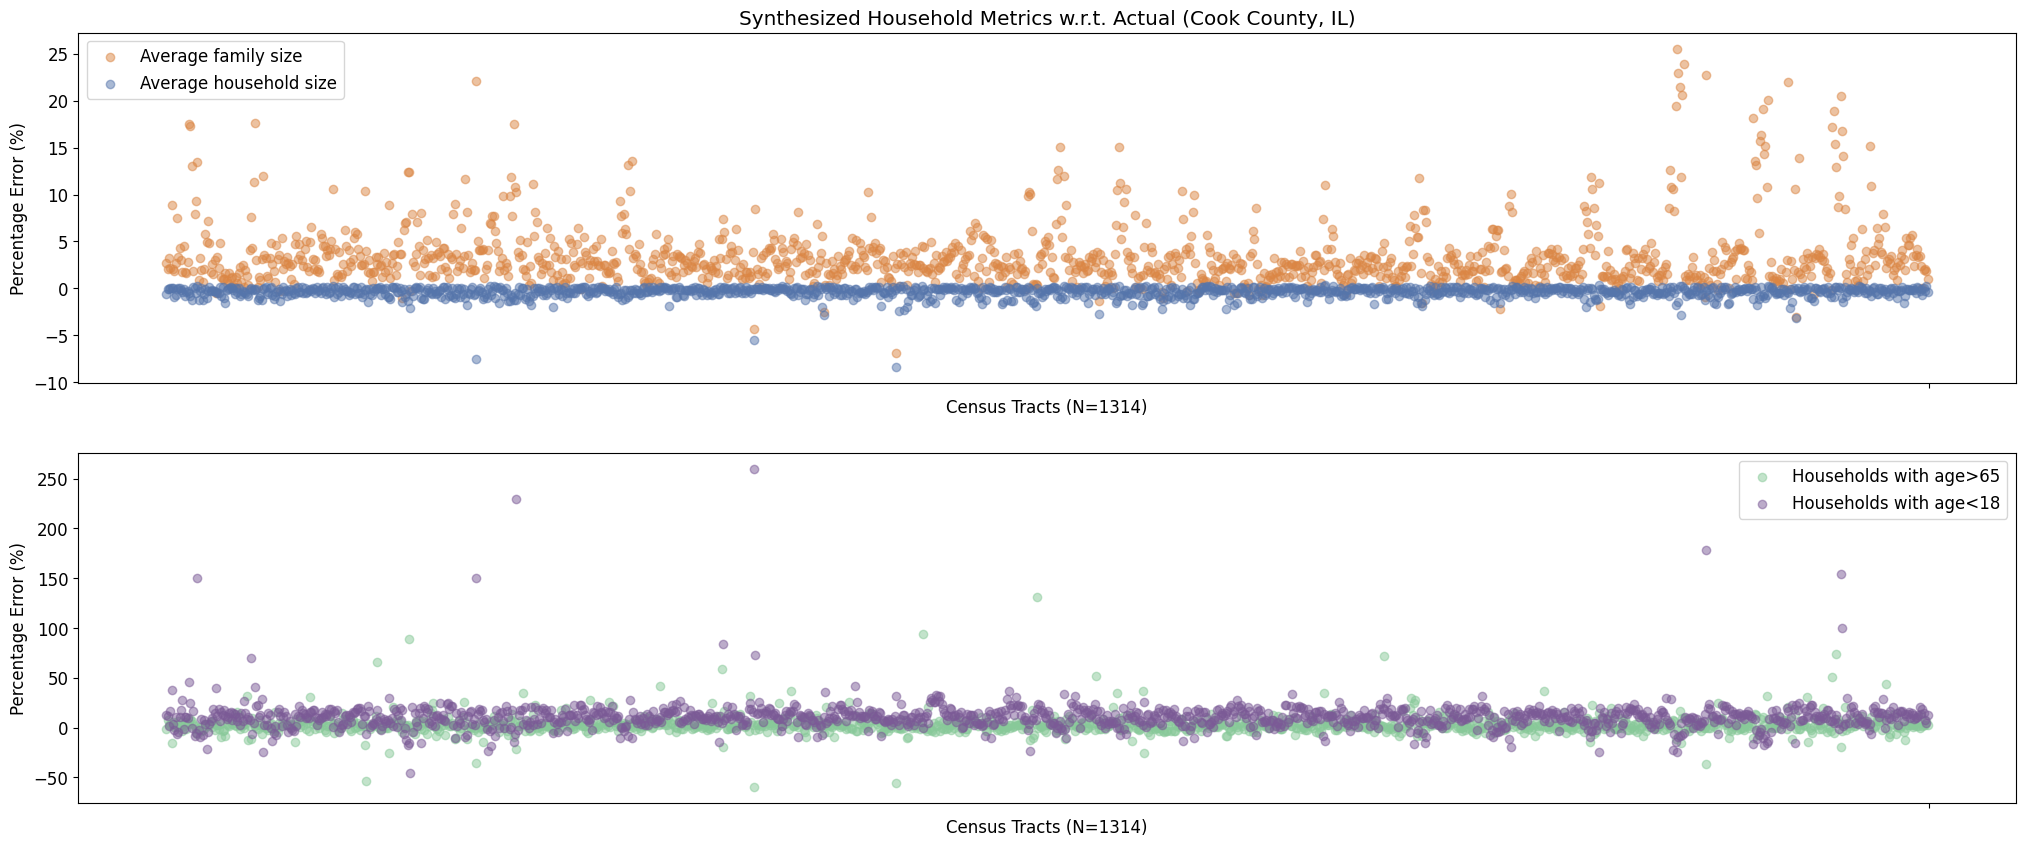

In [66]:
with open('output/errors.pkl', 'rb') as f:
    errors = pd.concat(pickle.load(f),axis=1).T

plt.rcParams.update({'font.size': 12})
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(25, 10))

ax1.scatter(errors.index, errors[['avg_family']], alpha=0.5, color = '#db8644')
ax1.scatter(errors.index, errors[['avg_hh']], alpha=0.5, color = '#5575ab',)
ax1.set(xticklabels='', xticks='', xlabel='Census Tracts (N=1314)',ylabel='Percentage Error (%)',
        title='Synthesized Household Metrics w.r.t. Actual (Cook County, IL)')
ax1.legend(labels=['Average family size', 'Average household size'])

ax2.scatter(errors.index, errors[['senior_hh']], alpha=0.5, color = '#88c999',)
ax2.scatter(errors.index, errors[['minor_hh']], alpha=0.5, color = '#7b5a96',)
ax2.set(xticklabels='', xticks='', xlabel='Census Tracts (N=1314)',ylabel='Percentage Error (%)')
ax2.legend(labels=['Households with age>65', 'Households with age<18'])
plt.savefig("plot/Percentage_errors.png")
plt.show(block=False)

6.2. Network statistics

In [58]:
G = load_graph('output/contact_network.gml')
G.set_directed(False)

In [63]:
print('# of nodes: {}\n# of edges: {}'.format(G.num_vertices(),G.num_edges()))
print('Clustering coefficient: {:.2f}'.format(gt.clustering.global_clustering(G)[0]))
print('Pseudo diameter: {}'.format(int(gt.topology.pseudo_diameter(G)[0])))
print('Average degree: {:.2f}'.format(gt.stats.vertex_average(G, 'total')[0]))
counts,bins = gt.stats.distance_histogram(G,samples=1000)
print('Average path length (N=1000): {:.2f}'.format((counts*bins[:-1]).sum()/counts.sum()))

# of nodes: 5170895
# of edges: 41519643
Clustering coefficient: 0.40
Pseudo diameter: 0
Average degree: 16.06
Average path length (N=1000): 8.29
